# 서울시 영화관 위치 분석(feat. 생활인구)
# 이지홍 (2022-05-22)

## 들어가며

서울특별시에 존재하는 **3대 영화관 브랜드(CGV, 메가박스, 롯데시네마)** 극장 위치(구 단위)를 웹 스크래핑 기법을 이용해 수집하였다. 추가적으로 이를 서울특별시의 일별 생활인구 데이터와 함께 비교하여, 생활인구와 영화관 입지 선정의 상관관계를 도출하여 보았다.

### 필요한 라이브러리

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import seaborn as sns
import time
import matplotlib.pyplot as plt
import json
## 노트북 상 plotting을 위해
%matplotlib inline

## 서울 지역 CGV 위치 정보 불러오기

### CGV 웹사이트 접속 후 위치 정보 URL 확보
* CGV는 'RegionCode'와 'TheaterCode'를 파라미터로 받음

In [2]:
RegionCode = "01" ##"서울"
TheaterCode = "0001" ## "CGV강변"
cgv_url = f"http://www.cgv.co.kr/theaters/?areacode={RegionCode}&theaterCode={TheaterCode}"
print(cgv_url)

http://www.cgv.co.kr/theaters/?areacode=01&theaterCode=0001


### requests를 이용해 BeautifulSoup을 활용
* 'RegionCode'와 'TheaterCode' 파싱
* CGV는 위 정보들을 javascript 함수로 json을 선언하고 있었는데, 그대로 불러와지지 않아서 고생함
* 보다 효율적인 방식이 있을 것 같은데 연습이 더 필요할듯...

In [3]:
# #contents > div.wrap-theater > div.sect-theater > div > div.box-contents > div.theater-info > strong
headers = {"user-agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.64 Safari/537.36"}
response = requests.get(cgv_url, headers = headers)
html = bs(response.text, 'lxml')
html_split = html.find_all("script", {"src":False})[3].get_text().replace(",\"TheaterName_ENG", "}*").replace("[", "*").replace("]", "*").replace("\"RegionCode", "*{\"RegionCode").split("*")
bool_json = [i.startswith("{\"RegionCode") and i.endswith("}") for i in html_split]
json_list = list(pd.Series(html_split).loc[bool_json])[:-1]
CGV_table = pd.DataFrame(columns = ["RegionCode", "TheaterCode", "TheaterName"])
for i in json_list:
    tmp = pd.read_json(i, orient = "index").T
    CGV_table = pd.concat([CGV_table, tmp])
CGV_table = CGV_table.reset_index(drop = True)
CGV_table

,RegionCode,TheaterCode,TheaterName
0,01,0056,CGV강남
1,01,0001,CGV강변
2,01,0229,CGV건대입구
3,01,0010,CGV구로
4,01,0063,CGV대학로
...,...,...,...
190,04,0336,CGV전주에코시티
191,04,0179,CGV전주효자
192,04,0186,CGV정읍
193,06,0302,CGV제주


* 전국 상영관중 서울지역(RegionCode : 01)에 해당하는 상영관들만 빼냄
* 특별관(TheaterCode가 P로 시작)의 경우 기존 일반상영관과 함께 위치하므로 제외(예: CGV용산아이파크몰, CINE de CHEF 용산아이파크몰)

In [4]:
CGV_seoul =  CGV_table[CGV_table['RegionCode'] == "01"][~CGV_table['TheaterCode'].str.contains('P')]
CGV_seoul

,RegionCode,TheaterCode,TheaterName
0,01,0056,CGV강남
1,01,0001,CGV강변
2,01,0229,CGV건대입구
3,01,0010,CGV구로
4,01,0063,CGV대학로
5,01,0252,CGV동대문
6,01,0230,CGV등촌
7,01,0009,CGV명동
8,01,0105,CGV명동역 씨네라이브러리
9,01,0011,CGV목동


### 페이지에서 구단위 지역정보만 뽑아오기
* 위에서 얻은 극장 코드(TheaterCode)를 이용해 상영관 주소에서 구정보만 파싱해 뽑아오는 함수 작성

In [5]:
def get_CGV_district(TheaterCode = str):
    RegionCode = "01" ## 서울 지역 코드
    cgv_url = f"http://www.cgv.co.kr/theaters/?areacode={RegionCode}&theaterCode={TheaterCode}"
    response = requests.get(cgv_url, headers =headers)
    html = bs(response.text, 'lxml')
    district = html.select("#contents > div.wrap-theater > div.sect-theater > div > div.box-contents > div.theater-info > strong")[0].get_text().split()[1]
    return district

TheaterCode = "0001" ## "CGV강변"
get_CGV_district(TheaterCode)

'광진구'

### 반복해서 구 정보 뽑아와서 데이터프레임에 저장

In [6]:
CGV_seoul["District"] = str
for i in range(len(CGV_seoul)):
    CGV_seoul["District"][i] = get_CGV_district(CGV_seoul["TheaterCode"][i])
    print('*', end = '')
    time.sleep(0.01)
print(f'{i}개 지점 완료'+ '*'* i)
CGV_seoul["Brand"] = "CGV"
CGV_seoul = CGV_seoul[["Brand", "TheaterName", "TheaterCode", "District"]]
CGV_seoul

******************************29개 지점 완료*****************************


,Brand,TheaterName,TheaterCode,District
0,CGV,CGV강남,0056,강남구
1,CGV,CGV강변,0001,광진구
2,CGV,CGV건대입구,0229,광진구
3,CGV,CGV구로,0010,구로구
4,CGV,CGV대학로,0063,종로구
5,CGV,CGV동대문,0252,중구
6,CGV,CGV등촌,0230,강서구
7,CGV,CGV명동,0009,중구
8,CGV,CGV명동역 씨네라이브러리,0105,중구
9,CGV,CGV목동,0011,양천구


### 서울특별시 구별 CGV 상영관 수

In [7]:
CGV_seoul["District"].value_counts()

강남구     3
중구      3
노원구     2
종로구     2
강북구     2
마포구     2
영등포구    2
광진구     2
송파구     1
용산구     1
성동구     1
서대문구    1
중랑구     1
성북구     1
은평구     1
도봉구     1
양천구     1
강서구     1
구로구     1
강동구     1
Name: District, dtype: int64

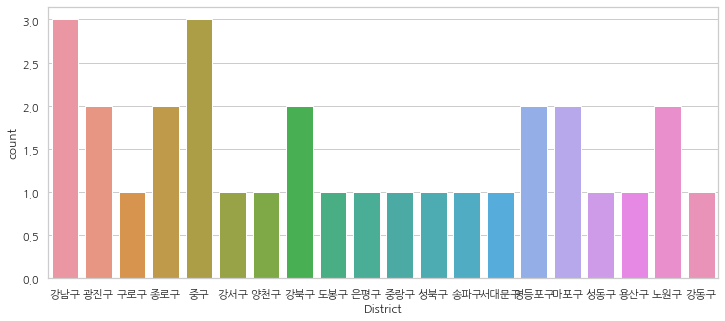

In [8]:
plt.figure(figsize= (12 , 5))
sns.countplot(data = CGV_seoul, x = "District")
plt.show()

## 서울 지역 메가박스 위치 정보 불러오기

### 메가박스 웹사이트 접속 후 위치 정보 URL 확보
* 메가박스는 'brchNo'를 파라미터로 받음(CGV의 'TheaterCode'와 상응하는 개념인듯 하여 변수명을 통일)

In [9]:
TheaterCode = "1372" #강남
url = f"https://www.megabox.co.kr/theater?brchNo={TheaterCode}"
print(url)

https://www.megabox.co.kr/theater?brchNo=1372


### requests를 이용해 BeautifulSoup을 활용
* '전체 극장 코드를 얻기 위해 아래와 같이 파싱

In [10]:
MB_url = "https://www.megabox.co.kr/theater/list"
response = requests.get(MB_url, headers = headers)

html = bs(response.text, "lxml")
# #contents > div > div.theater-box > div.theater-place > ul > li.on > div > ul > li:nth-child(1) > a
a_seoul = html.select("#contents > div > div.theater-box > div.theater-place > ul > li.on > div > ul > li > a")
MB_seoul = pd.DataFrame(columns = ["TheaterCode", "TheaterName", "District"], data = np.full((len(a_seoul), 3), None))
for i in range(len(a_seoul)):
    MB_seoul["TheaterCode"][i] = str(a_seoul[i]["href"].split("=")[-1])
    MB_seoul["TheaterName"][i] = str(a_seoul[i].get_text())
MB_seoul

,TheaterCode,TheaterName,District
0,1372,강남,None
1,0023,강남대로(씨티),None
2,1341,강동,None
3,1431,군자,None
4,1003,동대문,None
5,1572,마곡,None
6,1581,목동,None
7,1311,상봉,None
8,1211,상암월드컵경기장,None
9,1331,성수,None


### 페이지에서 구단위 지역정보만 뽑아오기
* 위에서 얻은 극장 코드(TheaterCode)를 이용해 상영관 주소에서 구정보만 파싱해 뽑아오는 함수 작성
* 메가박스의 경우 상영관 정보를 모아둔 페이지가 있어서 requests.post 방식으로 스크랩후 파싱

In [11]:
def get_MB_district(TheaterCode = str):
    url = "https://www.megabox.co.kr/on/oh/ohc/Brch/infoPage.do"
    ## areaCd": "10" ~ 서울지역 코드
    response = requests.post(url, headers, params = {"areaCd": "10", "brchNo": f"{TheaterCode}"})
    html = bs(response.text, "lxml")
    district = html.select("li")[["도로명주소" in str(k) for k in html.select("li")].index(True)].get_text().split(":  ")[1].split()[1]  
    district
    return district

In [12]:
TheaterCode = "1372" # 강남
get_MB_district(TheaterCode)

'서초구'

### 반복해서 구 정보 뽑아와서 데이터프레임에 저장

In [13]:
for i in MB_seoul["TheaterCode"]:
    MB_seoul["District"][MB_seoul["TheaterCode"] == i] = get_MB_district(i)
    print('*', end = '')
    time.sleep(0.01)
print(f'{len(MB_seoul)}개 지점 완료'+ '*'*len(MB_seoul))
MB_seoul["Brand"] = "메가박스"
MB_seoul = MB_seoul[["Brand", "TheaterName", "TheaterCode", "District"]]
MB_seoul

*******************19개 지점 완료*******************


,Brand,TheaterName,TheaterCode,District
0,메가박스,강남,1372,서초구
1,메가박스,강남대로(씨티),0023,강남구
2,메가박스,강동,1341,강동구
3,메가박스,군자,1431,광진구
4,메가박스,동대문,1003,중구
5,메가박스,마곡,1572,강서구
6,메가박스,목동,1581,양천구
7,메가박스,상봉,1311,중랑구
8,메가박스,상암월드컵경기장,1211,마포구
9,메가박스,성수,1331,성동구


### 서울특별시 구별 메가박스 상영관 수

In [14]:
MB_seoul["District"].value_counts()

서초구     2
강남구     2
강서구     2
마포구     2
동작구     2
강동구     1
광진구     1
중구      1
양천구     1
중랑구     1
성동구     1
송파구     1
서대문구    1
도봉구     1
Name: District, dtype: int64

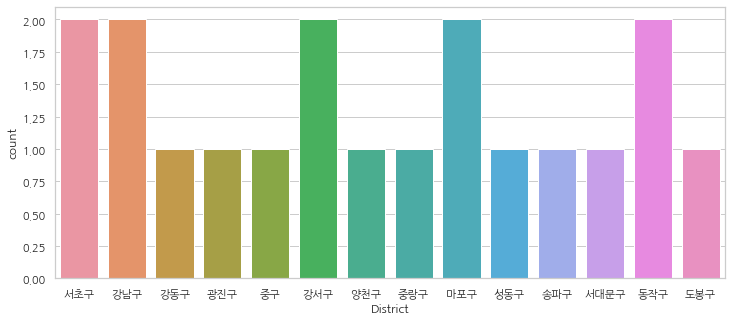

In [15]:
plt.figure(figsize= (12 , 5))
sns.countplot(data = MB_seoul, x = "District")
plt.show()

## 서울 지역 롯데시네마 위치 정보 불러오기

### 롯데시네마 웹사이트 접속 후 위치 정보 URL 확보
* 롯데시네마는 동적인 페이지들이 많아서 단순한 파싱이 어려움
* 다만 post를 통해 정확한 method를 사용하여 요청할 수 있다면, 데이터 수집이 쉬운편
* cinemaID = TheaterCode (CGV)

In [16]:
TheaterCode = "1013" #가산디지털
LC_url = f"https://www.lottecinema.co.kr/NLCHS/Cinema/Detail?divisionCode=1&detailDivisionCode=1&cinemaID={TheaterCode}"
print(LC_url)

https://www.lottecinema.co.kr/NLCHS/Cinema/Detail?divisionCode=1&detailDivisionCode=1&cinemaID=1013


### requests를 이용해 BeautifulSoup을 활용
* '전체 극장 코드를 얻기 위해 아래와 같이 파싱
* 전체 극장 코드를 불러올 방법을 찾지 못하다가 "GetCinemaItems"라는 methodname을 인터넷에서 찾아서 참고함
> 출처: <https://github.com/dlwlgjs132/movieCo/blob/master/lotte.py>

In [17]:
url = "https://www.lottecinema.co.kr/LCWS/Cinema/CinemaData.aspx" 
dic = {"MethodName":"GetCinemaItems","channelType":"HO","osType":"W","osVersion":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.64 Safari/537.36","multiLanguageID":"KR"}
data = {"paramList" : str(dic)}
headers = {"user-agent" : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36"}
response = requests.post(url, headers = headers, data=data).json()

### 페이지에서 구단위 지역정보만 뽑아오기
* 위에서 얻은 극장 코드(TheaterCode)를 이용해 상영관 주소에서 구정보만 파싱해 뽑아오는 함수 작성
* 메가박스의 경우 상영관 정보를 모아둔 페이지가 있어서 requests.post 방식으로 스크랩후 파싱

In [18]:
def get_LC_district(TheaterCode = str):
    url = "https://www.lottecinema.co.kr/LCWS/Cinema/CinemaData.aspx"  
    RegionCode = "1" ## 서울
    dic = {"MethodName":"GetCinemaDetailItem","channelType":"HO","osType":"Chrome","osVersion":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36","divisionCode": f"{RegionCode}","detailDivisionCode":"1","cinemaID": f"{TheaterCode}","memberOnNo":"0"}

    # params = {"paramList" : str(dic).encode()}
    data = {"paramList" : str(dic)}
    response = requests.post(url, data=data).json()
    district = response["CinemaDetail"]["Address"].split()[1]
    return district

In [19]:
TheaterCode = "1013" #가산디지털
get_LC_district(TheaterCode)

'금천구'

### 반복해서 구 정보 뽑아와서 데이터프레임에 저장

In [20]:
LC_table = pd.DataFrame(response["Cinemas"]["Items"]).dropna(axis = 1)
LC_seoul = LC_table[LC_table["DetailDivisionCode"] == "0001"][["DivisionCode", "CinemaID", "CinemaNameKR"]]
LC_seoul.columns = ["DivisionCode", "TheaterCode", "TheaterName"]
LC_seoul["District"] = str

for i in LC_seoul["TheaterCode"]:
    LC_seoul["District"][LC_seoul["TheaterCode"] == i] = get_LC_district(i)
    time.sleep(0.01)
    print('*', end = '')
    time.sleep(0.01)
print(f'{len(LC_seoul)}개 지점 완료'+ '*'*len(LC_seoul))
LC_seoul["Brand"] = "롯데시네마"
LC_seoul = LC_seoul[["Brand", "TheaterName", "TheaterCode", "District"]]
LC_seoul

***********************23개 지점 완료***********************


,Brand,TheaterName,TheaterCode,District
0,롯데시네마,가산디지털,1013,금천구
1,롯데시네마,가양,9094,강서구
2,롯데시네마,강동,9010,강동구
3,롯데시네마,건대입구,1004,광진구
4,롯데시네마,김포공항,1009,강서구
5,롯데시네마,노원,1003,노원구
6,롯데시네마,도곡,1023,강남구
7,롯데시네마,독산,1017,금천구
8,롯데시네마,브로드웨이(신사),9056,강남구
9,롯데시네마,서울대입구,1012,관악구


### 서울특별시 구별 롯데시네마 상영관 수

In [21]:
LC_seoul["District"].value_counts()

금천구     2
강남구     2
강서구     2
관악구     2
마포구     2
노원구     2
광진구     1
강북구     1
강동구     1
중구      1
영등포구    1
용산구     1
송파구     1
은평구     1
중랑구     1
동대문구    1
구로구     1
Name: District, dtype: int64

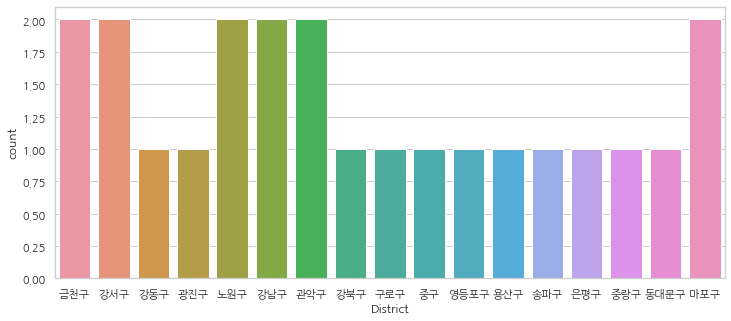

In [22]:
plt.figure(figsize= (12 , 5))
sns.countplot(data = LC_seoul, x = "District")
plt.show()

## 서울 지역 3개 극장 브랜드 위치 분석
### 3개 극장 데이터 합치기

In [23]:
theaters = pd.concat([CGV_seoul, MB_seoul, LC_seoul])

### 3개 영화관 브랜드 및 구별 상영관 수
* 서울 시내에는 **CGV > 롯데시내마 > 메가박스** 순으로 극장이 많았고, 가장 많은 극장이 있는 구는 **강남구**였다.

In [24]:
pd.pivot_table(data = theaters, index="District", columns = "Brand", values = "TheaterName", aggfunc = "count", fill_value= 0,margins=True)

Brand,CGV,롯데시네마,메가박스,All
District,,,,
강남구,3,2,2,7
강동구,1,1,1,3
강북구,2,1,0,3
강서구,1,2,2,5
관악구,0,2,0,2
광진구,2,1,1,4
구로구,1,1,0,2
금천구,0,2,0,2
노원구,2,2,0,4


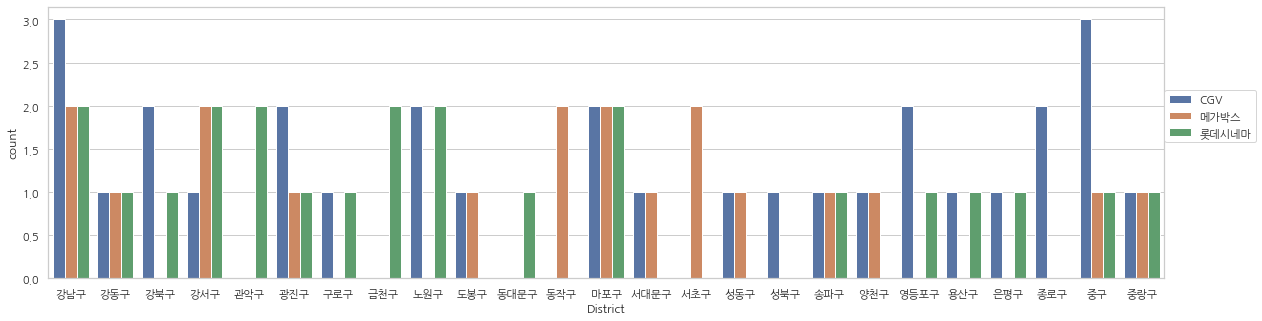

In [25]:
plt.figure(figsize= (20 , 5))
sns.countplot(data = theaters, x = "District",hue = "Brand", order = theaters["District"].sort_values().unique())
plt.legend(loc = (1, 0.5))
plt.show()

## 서울특별시 생활인구 API 불러오기
서울 열린데이터 광장에서는 여러가지 공공데이터를 제공하는데, 이중 서울 생활인구 데이터를 불러와 극장의 입지와 얼마나 관련이 있는지 검증해보고자 하였다. 
>서울 생활인구: 서울시와 KT가 공공빅데이터와 통신데이터를 이용하여 추계한 서울의 특정지역, 특정시점에 존재하는 모든 인구
>
>출처: 서울 열린데이터 광장
<https://data.seoul.go.kr/dataVisual/seoul/seoulLivingMigration.do>

### api를 이용하여 데이터 불러오기
* api key 발급이 요구됨(절차는 간단)
* 자료가 업데이트된 가장 최근인 "20220517"의 데이터를 사용
* json형태로 데이터를 불러와 데이블로 활용
* "Date: 기준일, "District" : 구 이름, "LVPOP_CNT" : 생활인구 수(Living population count)로 컬럼명 변경

In [26]:
api_key = "*************************************"
date = '20220517'
seoul_api_url = f'http://openapi.seoul.go.kr:8088/{api_key}/json/SPOP_DAILYSUM_JACHI/1/100/{date}'
# print(seoul_api_url)
response = requests.get(seoul_api_url)
pop_data = pd.DataFrame.from_dict(response.json()["SPOP_DAILYSUM_JACHI"]['row'])[1:]
pop_data = pop_data[["STDR_DE_ID", "SIGNGU_NM", "TOT_LVPOP_CO"]]
pop_data.columns = ["Date", "District", "LVPOP_CNT"]
pop_data["LVPOP_CNT"] = pd.to_numeric(pop_data["LVPOP_CNT"])

### 서울시 구별 생활인구수 (20220517 기준)
* 가장 인구가 많은 곳은 **강남구**이고 가장 적은 곳은 **금천구**였다.

In [27]:
pop_data

,Date,District,LVPOP_CNT
1,20220517,종로구,331165.0542
2,20220517,중구,334847.2981
3,20220517,용산구,316447.8455
4,20220517,성동구,373655.3488
5,20220517,광진구,385752.1444
6,20220517,동대문구,385987.6438
7,20220517,중랑구,351830.3968
8,20220517,성북구,445233.4077
9,20220517,강북구,288522.7538
10,20220517,도봉구,270811.7800


In [28]:
pop_data[(pop_data["LVPOP_CNT"] == pop_data["LVPOP_CNT"].max()) | (pop_data["LVPOP_CNT"] == pop_data["LVPOP_CNT"].min())]

,Date,District,LVPOP_CNT
18,20220517,금천구,248524.8804
23,20220517,강남구,916672.4236


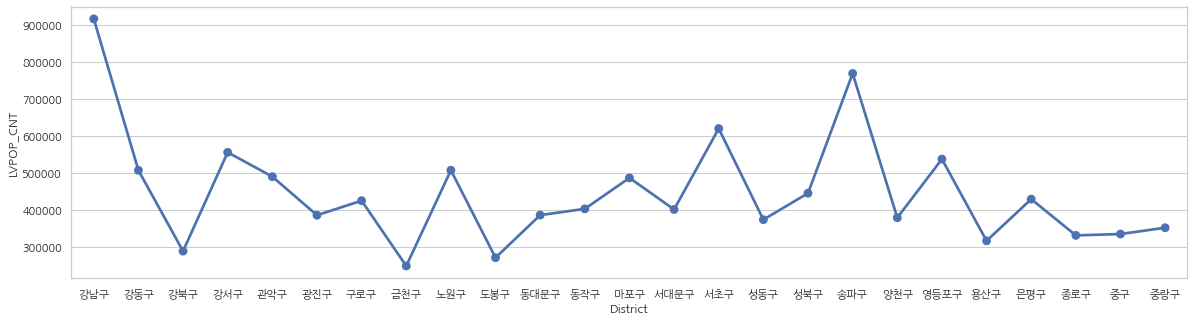

In [29]:
plt.figure(figsize= (20 , 5))
sns.pointplot(data = pop_data, x = "District", y = "LVPOP_CNT", order = theaters["District"].sort_values().unique())
plt.show()

### 극장 데이터와 인구수 데이터 합치기

In [30]:
theaters = theaters.merge(pop_data, on =  "District")
theaters

,Brand,TheaterName,TheaterCode,District,Date,LVPOP_CNT
0,CGV,CGV강남,0056,강남구,20220517,916672.4236
1,CGV,CGV압구정,0040,강남구,20220517,916672.4236
2,CGV,CGV청담씨네시티,0107,강남구,20220517,916672.4236
3,메가박스,강남대로(씨티),0023,강남구,20220517,916672.4236
4,메가박스,코엑스,1351,강남구,20220517,916672.4236
...,...,...,...,...,...,...
67,롯데시네마,가산디지털,1013,금천구,20220517,248524.8804
68,롯데시네마,독산,1017,금천구,20220517,248524.8804
69,롯데시네마,서울대입구,1012,관악구,20220517,490029.7536
70,롯데시네마,신림,1007,관악구,20220517,490029.7536


* 대체로 생활인구수가 많은 지역(예: 강남구)에 극장도 많은 것처럼 보이지만 그렇지 않은(예: 송파구)도 보인다.

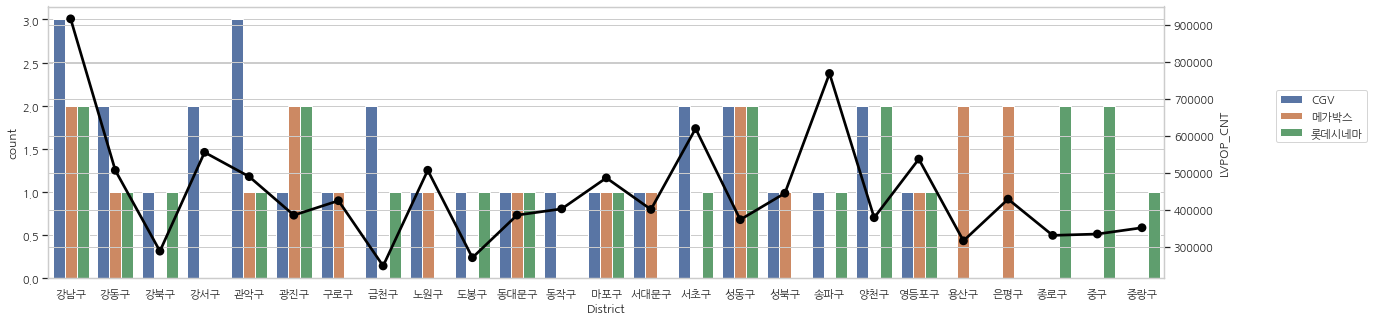

In [31]:
plt.figure(figsize= (20 , 5))
ax = sns.countplot(data = theaters, x = "District",hue = "Brand")
plt.legend(loc = (1.1, 0.5))
ax2 = ax.twinx()
g2 = sns.pointplot(data = pop_data, x = "District", y = "LVPOP_CNT", order = theaters["District"].sort_values().unique(), ax = ax2, color = "black")
plt.show()

### 각 브랜드 및 구별 극장수와 생활인구수 비교
* 각 브랜드별 생활인구수는 구별 인구수가 동일하므로 그냥 groupby 후 산술평균을 취하였고, 각 인구수는 구별 극장수는 count를 취하였다.

In [32]:
theater_district = pd.DataFrame(theaters.groupby(["Brand", "District"]).mean("LVPOP_CNT"))
theater_district["Theater_CNT"] = pd.to_numeric(theaters.groupby(["Brand", "District"])["District"].count())
theater_district = theater_district.reset_index()
theater_district

,Brand,District,LVPOP_CNT,Theater_CNT
0,CGV,강남구,916672.4236,3
1,CGV,강동구,507112.0533,1
2,CGV,강북구,288522.7538,2
3,CGV,강서구,555780.1910,1
4,CGV,광진구,385752.1444,2
5,CGV,구로구,424965.9044,1
6,CGV,노원구,507223.9251,2
7,CGV,도봉구,270811.7800,1
8,CGV,마포구,486651.3290,2
9,CGV,서대문구,401266.1642,1


### 각 구별 전체 극장 수와 생활인구수 비교
* 편의상 먼저 계산한 극장, 구별 인구수(theater_district)를 이용해 구별 극장 수 및 생활인구수 계산
* 구(District)별 groupby 후 극장 수(Theater_CNT")는 합치고 생활인구수("LVPOP_CNT")는 동일한 값이 사용됐으므로 간단히 평균

In [33]:
all_theater_district = theater_district.groupby(["District"]).agg({"Theater_CNT" : "sum", "LVPOP_CNT": "mean"})
all_theater_district

,Theater_CNT,LVPOP_CNT
District,,
강남구,7,916672.4236
강동구,3,507112.0533
강북구,3,288522.7538
강서구,5,555780.1910
관악구,2,490029.7536
광진구,4,385752.1444
구로구,2,424965.9044
금천구,2,248524.8804
노원구,4,507223.9251


### 극장 수와 생활인구수의 상관계수
* 수치형 변수들의 상관을 구하기위해 Pearson 상관을 사용

* 전체 극장수와 생활인구수는 0.51 정도의 상관을 보였다.

In [34]:
all_theater_district.corr(method = 'pearson')

,Theater_CNT,LVPOP_CNT
Theater_CNT,1.000000,0.506665
LVPOP_CNT,0.506665,1.000000


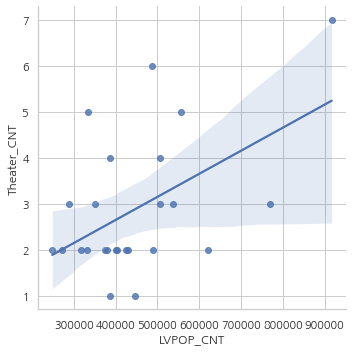

In [35]:
sns.lmplot(data = all_theater_district, x= "LVPOP_CNT", y = "Theater_CNT")
plt.show()

* 각 브랜드별로 각 구의 극장 수와 인구수 별 상관은 **메가박스**(*r* = 0.49) > **롯데시네마**(*r* = 0.30) > **CGV**(*r* = 0.26) 순이었다.

In [36]:
theater_district.groupby("Brand").corr(method = 'pearson')

LVPOP_CNT  Theater_CNT
Brand                                    
CGV   LVPOP_CNT     1.000000     0.257310
      Theater_CNT   0.257310     1.000000
롯데시네마 LVPOP_CNT     1.000000     0.302359
      Theater_CNT   0.302359     1.000000
메가박스  LVPOP_CNT     1.000000     0.487715
      Theater_CNT   0.487715     1.000000

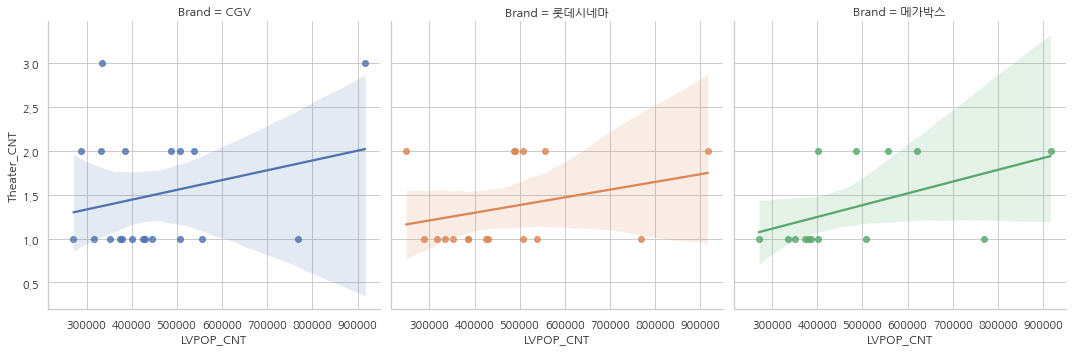

In [37]:
sns.lmplot(data = theater_district, x = "LVPOP_CNT", y = "Theater_CNT", hue = "Brand", col = "Brand")
plt.show()

## 결론
* 서울 시내 주요 브랜드 극장들의 위치는 각 구별 생활인구와 꽤 상관(*r* = 0.51)이 있는 것으로 보인다. 이는 생활인구가 극장 입지 선정에 영향을 미쳤을 가능성을 시사하나, 추가적인 분석을 통해 인과적인 판단이 필요할 듯하다.
* 각 브랜드별 극장 위치는 생활인구와의 상관이 항상 높지는 않은데, 이는 경쟁사들의 선점된 입지가 극장 위치에 선정에 영향을 미쳤을 가능성이 있다.

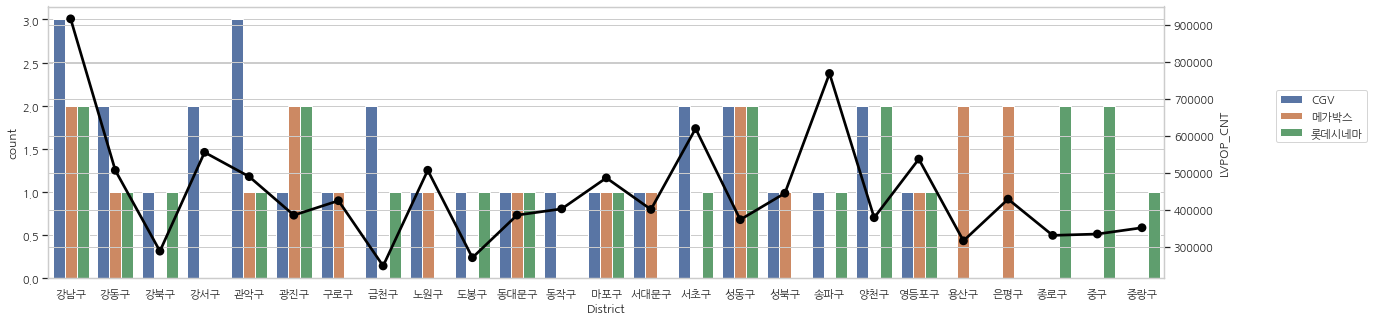

In [38]:
plt.figure(figsize= (20 , 5))
ax = sns.countplot(data = theaters, x = "District",hue = "Brand")
plt.legend(loc = (1.1, 0.5))
ax2 = ax.twinx()
g2 = sns.pointplot(data = pop_data, x = "District", y = "LVPOP_CNT", order = theaters["District"].sort_values().unique(), ax = ax2, color = "black")
plt.show()

## 마치며
* 웹 스크래핑을 활용한 첫번째 프로젝트는 매우 재미있었다. 아직 파이썬의 문법이 익숙하지 않아서 어려움이 있었고 앞으로도 많은 연습이 필요할 것 같다.
* 생활인구 뿐만 아니라 **서울 생활이동 인구** 데이터도 분석에 사용하고 싶었으나, API 형태로 제공되지 않아서 다음으로 미뤘다. 생활이동 인구 데이터를 활용하면, 유동인구가 극장 입지에 미치는 영향을 살펴볼 수 있을 것 같다.
> 서울 생활이동 인구: 서울 안에서 이동하거나 서울 외부에서 서울로 오고 간 이동으로 통근, 통학, 쇼핑, 여가 등 행정수요를 유발하는 모든 이동
>
> 출처: 서울 열린데이터 광장 
<https://data.seoul.go.kr/dataVisual/seoul/seoulLivingMigration.do>